# Mars Media & Weather – API Scraping Project

## Objective
In this project, we (1) collect **Mars-related images** and metadata from the **NASA Images API**, and (2) attempt to fetch **Mars weather** observations (InSight / Exoplanet Archive as fallback) to explore simple relationships and to demonstrate API scraping techniques.

**Research questions (example):**
- What recent Mars image topics are most common?
- How do image publication dates distribute over time?
- (If weather data available) What does a typical sol’s temperature/pressure look like?

## Data Sources
- NASA Images API — https://images.nasa.gov/docs/images.nasa.gov_api_docs.pdf
- InSight: Mars Weather Service API (historical; may be unavailable) — https://api.nasa.gov/
- NASA Exoplanet Archive (used only as a JSON/CSV parsing fallback demo) — https://exoplanetarchive.ipac.caltech.edu/

> If InSight weather is unavailable, the notebook will skip that section gracefully.

## Method / Approach
1. Use `requests` to call each API with **parameters** and optional **headers**.
2. Wrap calls in reusable functions with:
   - `response.raise_for_status()` and status checks
   - **`try/except`** around the request
   - Simple **retry/backoff** for transient errors (429/5xx)
   - Safe JSON access with `.get(...)`
3. Normalize results into **clean pandas DataFrames**.
4. Present:
   - A tidy preview (`df.head()`), types, and basic stats
   - At least one **plot** (matplotlib)
   - A brief **discussion/limitations**

In [1]:
# Imports
import os, time, math, json, typing as t
from datetime import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_columns", None)

In [2]:
# Configuration
NASA_API_KEY = os.getenv("fPgPWhtB3vg7XIt7MvlCW0bmaFo86LMH2K5SnG4g")  # replace with your key or set an env var
TOPICS = ["Mars rover", "Curiosity", "Perseverance"]
MAX_ITEMS_PER_TOPIC = 10  # limit for demo

# Endpoints
NASA_IMAGES_SEARCH = "https://images-api.nasa.gov/search"
# Historical/Deprecated InSight Mars Weather (may be unavailable). We'll handle failures gracefully.
INSIGHT_WEATHER = "https://api.nasa.gov/insight_weather/?api_key={api_key}&feedtype=json&ver=1.0"

# Helper: simple retry/backoff
def get_with_retry(url: str, *, params: dict | None = None, headers: dict | None = None, tries: int = 3, backoff: float = 1.5):
    last_err = None
    for i in range(tries):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=20)
            if r.status_code in (429, 500, 502, 503, 504):
                time.sleep(backoff ** i)
                last_err = RuntimeError(f"Transient HTTP {r.status_code}")
                continue
            r.raise_for_status()
            return r
        except requests.RequestException as e:
            last_err = e
            time.sleep(backoff ** i)
    raise last_err

### Part A — NASA Images API

In [3]:
# Fetch Mars-related images for selected topics
rows: list[dict] = []
for topic in TOPICS:
    try:
        resp = get_with_retry(NASA_IMAGES_SEARCH, params={"q": topic, "media_type": "image"})
        data = resp.json()
        items = (data.get("collection", {}).get("items") or [])[:MAX_ITEMS_PER_TOPIC]
        for it in items:
            info = (it.get("data") or [{}])[0]
            link = (it.get("links") or [{}])[0].get("href")
            rows.append({
                "topic": topic,
                "title": info.get("title"),
                "description": info.get("description"),
                "date_created": info.get("date_created"),
                "nasa_id": info.get("nasa_id"),
                "media_type": info.get("media_type"),
                "thumbnail": link,
            })
    except Exception as e:
        print(f"[WARN] Topic '{topic}' failed: {e}")

df_images = pd.DataFrame(rows)
# Clean types
if not df_images.empty:
    df_images["date_created"] = pd.to_datetime(df_images["date_created"], errors="coerce")
df_images.head()

,topic,title,description,date_created,nasa_id,media_type,thumbnail
0,Mars rover,Mars Rover Studies Soil on Mars,Mars Rover Studies Soil on Mars,2004-11-30 21:29:24+00:00,PIA07081,image,https://images-assets.nasa.gov/image/PIA07081/...
1,Mars rover,Frost on Mars Rover Opportunity,Frost on Mars Rover Opportunity,2004-12-13 16:58:00+00:00,PIA07108,image,https://images-assets.nasa.gov/image/PIA07108/...
2,Mars rover,Artist Concept of Rover on Mars,An artist concept portrays a NASA Mars Explora...,2003-02-26 21:03:33+00:00,PIA04413,image,https://images-assets.nasa.gov/image/PIA04413/...
3,Mars rover,Mars Exploration Rover,Mars Exploration Rover MER spacecraft -- areos...,2003-10-30 21:34:03+00:00,PIA04824,image,https://images-assets.nasa.gov/image/PIA04824/...
4,Mars rover,Mars Exploration Rover,Mars Exploration Rover MER spacecraft -- areos...,2003-10-30 21:34:01+00:00,PIA04823,image,https://images-assets.nasa.gov/image/PIA04823/...


Rows: 30
topic                        object
title                        object
description                  object
date_created    datetime64[ns, UTC]
nasa_id                      object
media_type                   object
thumbnail                    object
dtype: object


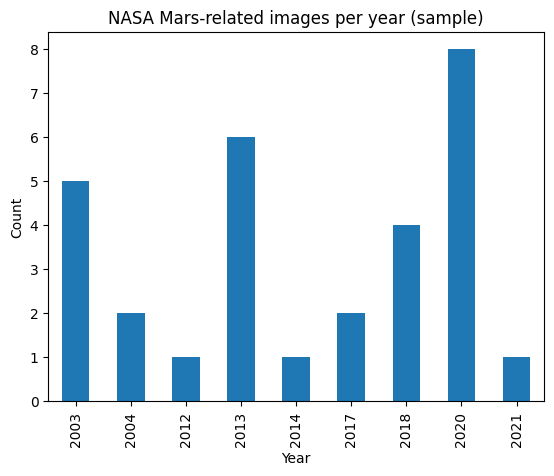

In [4]:
# Quick summary/visualization for images
if not df_images.empty:
    print("Rows:", len(df_images))
    print(df_images.dtypes)
    # Plot images per year
    year_counts = df_images.dropna(subset=["date_created"]).assign(year=lambda d: d["date_created"].dt.year).groupby("year").size()
    plt.figure()
    year_counts.plot(kind="bar")
    plt.title("NASA Mars-related images per year (sample)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()
else:
    print("No image data collected.")

### Part B — (Attempt) InSight Mars Weather

In [8]:
# Attempt to fetch InSight Mars weather (may fail)
try:
    url = INSIGHT_WEATHER.format(api_key= "fPgPWhtB3vg7XIt7MvlCW0bmaFo86LMH2K5SnG4g")
    r = get_with_retry(url)
    js = r.json()
    # Normalize a typical InSight JSON if available
    sols = [k for k in js.keys() if k.isdigit()]
    weather_rows = []
    for sol in sols:
        sol_data = js.get(sol) or {}
        weather_rows.append({
            "sol": int(sol),
            "First_UTC": pd.to_datetime(sol_data.get("First_UTC")) if sol_data.get("First_UTC") else None,
            "Last_UTC": pd.to_datetime(sol_data.get("Last_UTC")) if sol_data.get("Last_UTC") else None,
            "AT_av": (sol_data.get("AT") or {}).get("av"),
            "AT_mn": (sol_data.get("AT") or {}).get("mn"),
            "AT_mx": (sol_data.get("AT") or {}).get("mx"),
            "HWS_av": (sol_data.get("HWS") or {}).get("av"),
            "PRE_av": (sol_data.get("PRE") or {}).get("av"),
        })
    df_weather = pd.DataFrame(weather_rows).sort_values("sol")
except Exception as e:
    print(f"[INFO] InSight weather unavailable: {e}")
    df_weather = pd.DataFrame()

df_weather.head()

,sol,First_UTC,Last_UTC,AT_av,AT_mn,AT_mx,HWS_av,PRE_av
0,675,2020-10-19 18:32:20+00:00,2020-10-20 19:11:55+00:00,-62.314,-96.872,-15.908,7.233,750.563
1,676,2020-10-20 19:11:55+00:00,2020-10-21 19:51:31+00:00,-62.812,-96.912,-16.499,8.526,749.090
2,677,2020-10-21 19:51:31+00:00,2020-10-22 20:31:06+00:00,-63.056,-97.249,-16.853,7.887,748.698
3,678,2020-10-22 20:31:06+00:00,2020-10-23 21:10:41+00:00,-62.562,-97.728,-9.055,5.246,743.741
4,679,2020-10-23 21:10:41+00:00,2020-10-24 21:50:16+00:00,-62.551,-96.644,-11.561,5.565,744.529


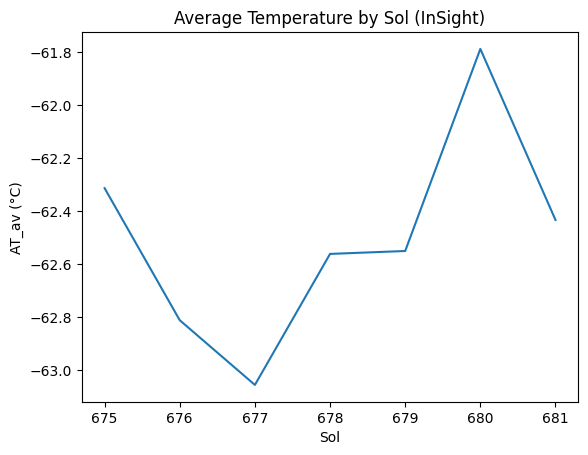

In [9]:
# If weather available, show a small plot
if not df_weather.empty and df_weather["AT_av"].notna().any():
    plt.figure()
    df_weather.set_index("sol")["AT_av"].plot()
    plt.title("Average Temperature by Sol (InSight)")
    plt.xlabel("Sol")
    plt.ylabel("AT_av (°C)")
    plt.show()
else:
    print("No weather data to plot.")

## Discussion & Limitations
- The NASA Images API provides rich metadata but may include duplicates and inconsistent fields.
- The InSight weather API has historically gone offline; this notebook handles that by skipping Part B if it fails.
- This is a sample; for a full study, add pagination, more topics, and richer validation.

## Next Steps
- Add rate limit awareness (e.g., global throttling across topics).
- Persist results to `csv`/`parquet` and include basic tests for schema.

In [ ]:
# Optional: Save outputs
if not df_images.empty:
    df_images.to_csv("nasa_images.csv", index=False)
    print("Saved nasa_images.csv")
if 'df_weather' in globals() and not df_weather.empty:
    df_weather.to_csv("insight_weather.csv", index=False)
    print("Saved insight_weather.csv")